In [2]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm

from utils import *
from help import *

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


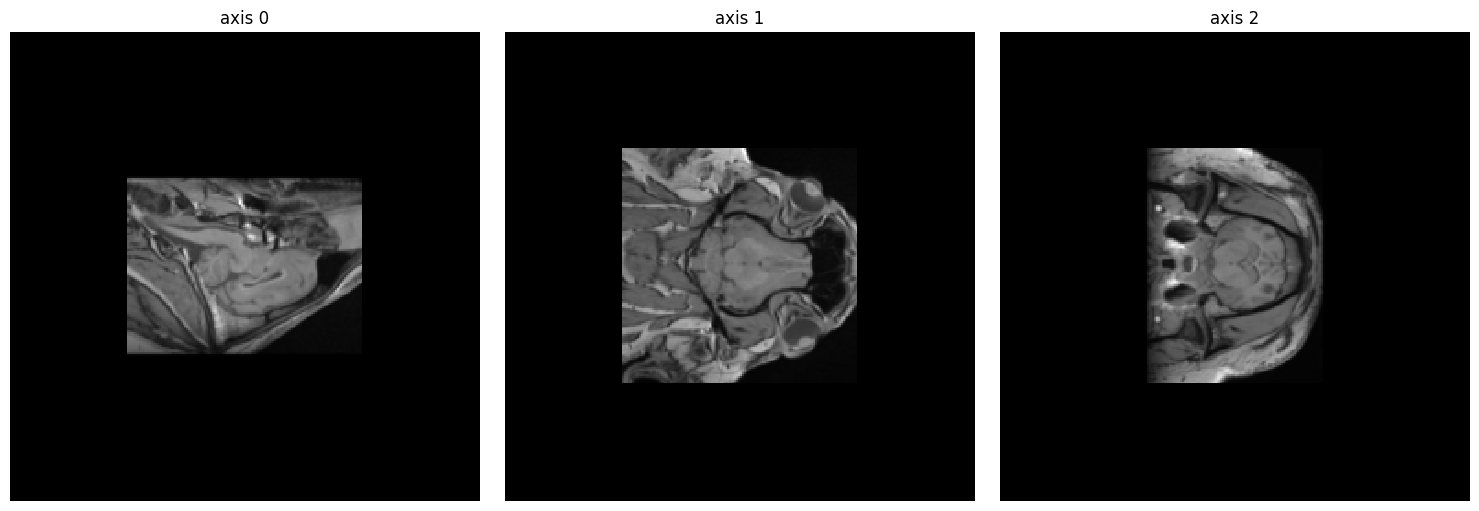

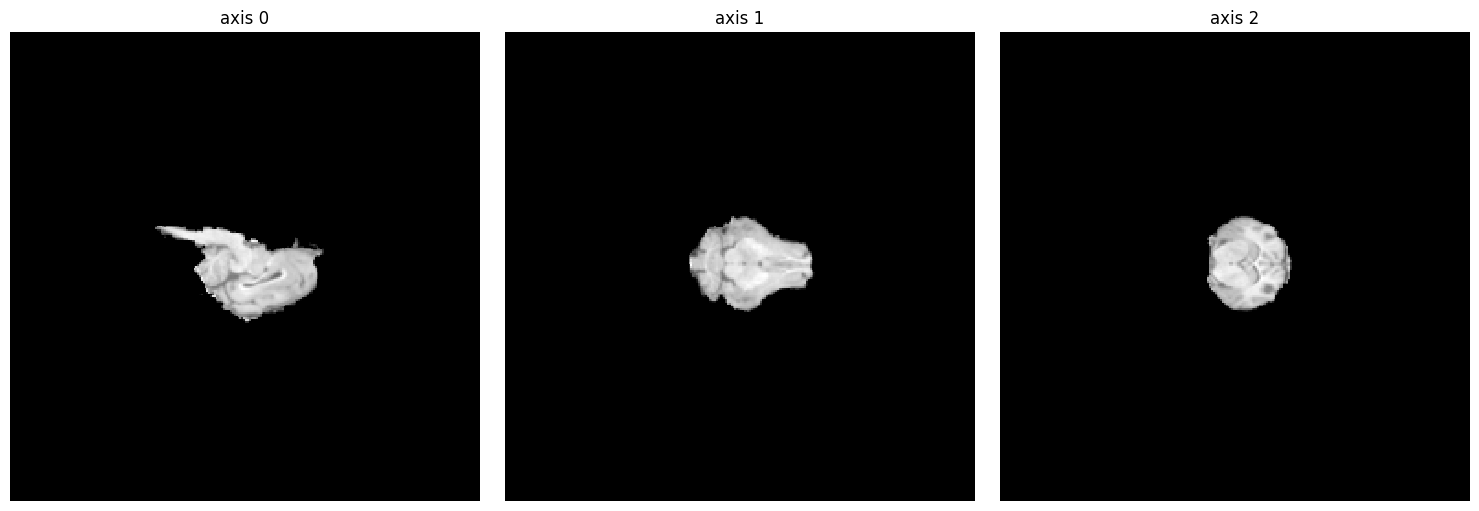

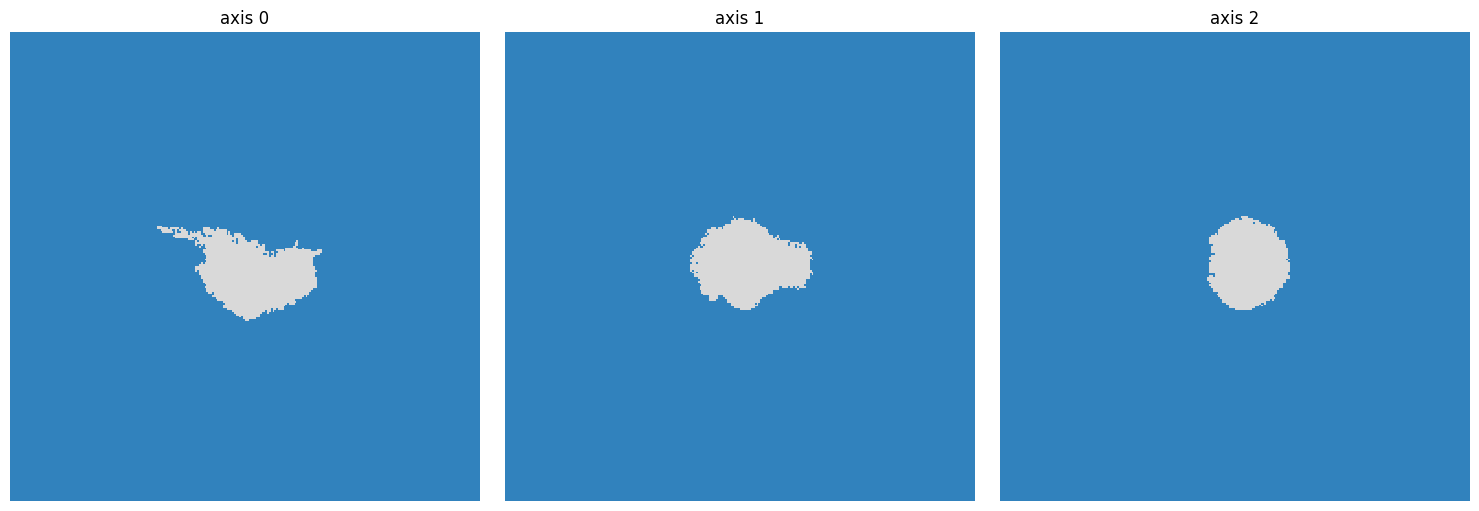

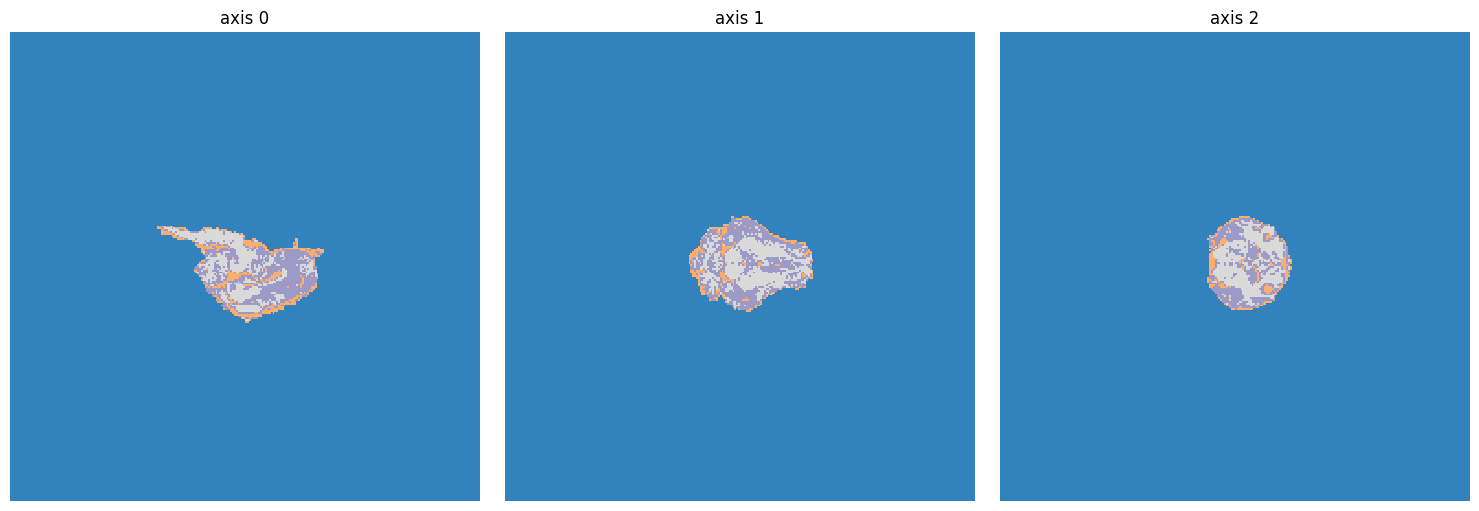

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [3]:
# folder_path = "/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7646/anat"
folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"

from scipy.ndimage import zoom

geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_seg = sf.load_volume(os.path.join(folder_path, 'fast_segmentation_seg.nii.gz')).resize(1).reshape([param_3d.img_size_256,]*3).data

pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_256,]*3).data
sigma = 1  # Adjust sigma for desired smoothing effect
pig_anat = gaussian_filter(pig_anat, sigma=sigma)

pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_256,]*3).data
pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_brain = pig_anat * (pig_brain_mask == 1)
scaling_factor = 0.5
pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain = sf.Volume(zoom(pig_brain, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_seg = sf.Volume(zoom(pig_seg, scaling_factor, order=1)).reshape((256,)*3)

ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask,cmaps=['tab20c'])
ne.plot.volume3D(pig_seg,cmaps=['tab20c'])

In [ ]:
pig_seg = sf.load_volume(os.path.join(folder_path, 'fast_segmentation_seg.nii.gz')).resize(1).reshape([param_3d.img_size_256,]*3).data


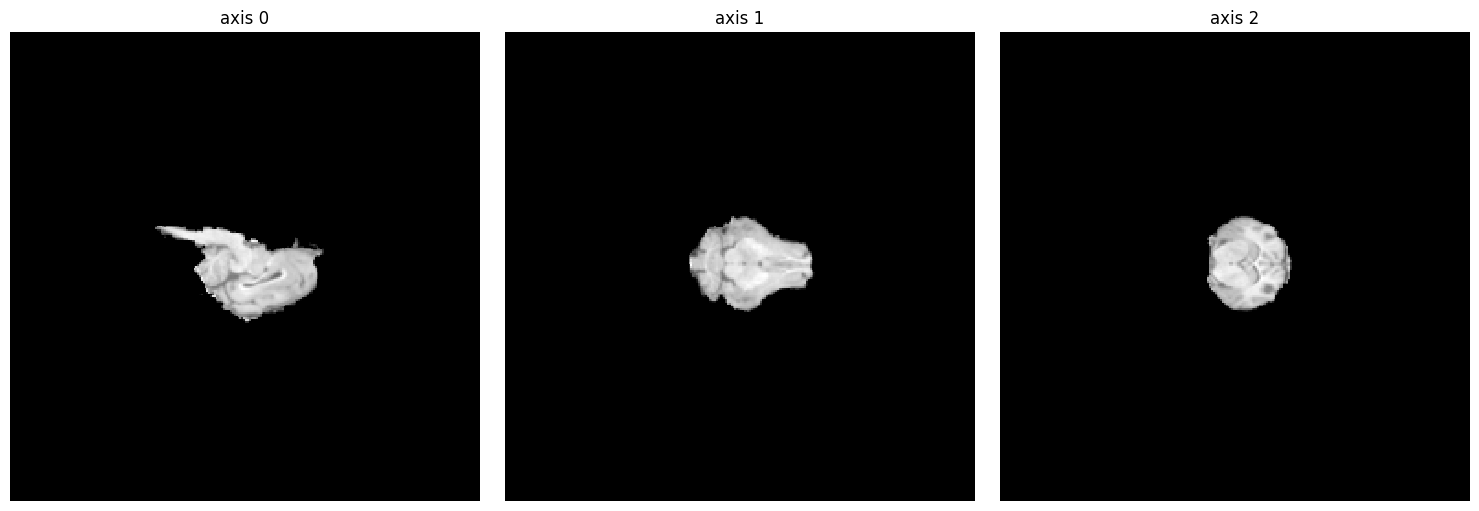

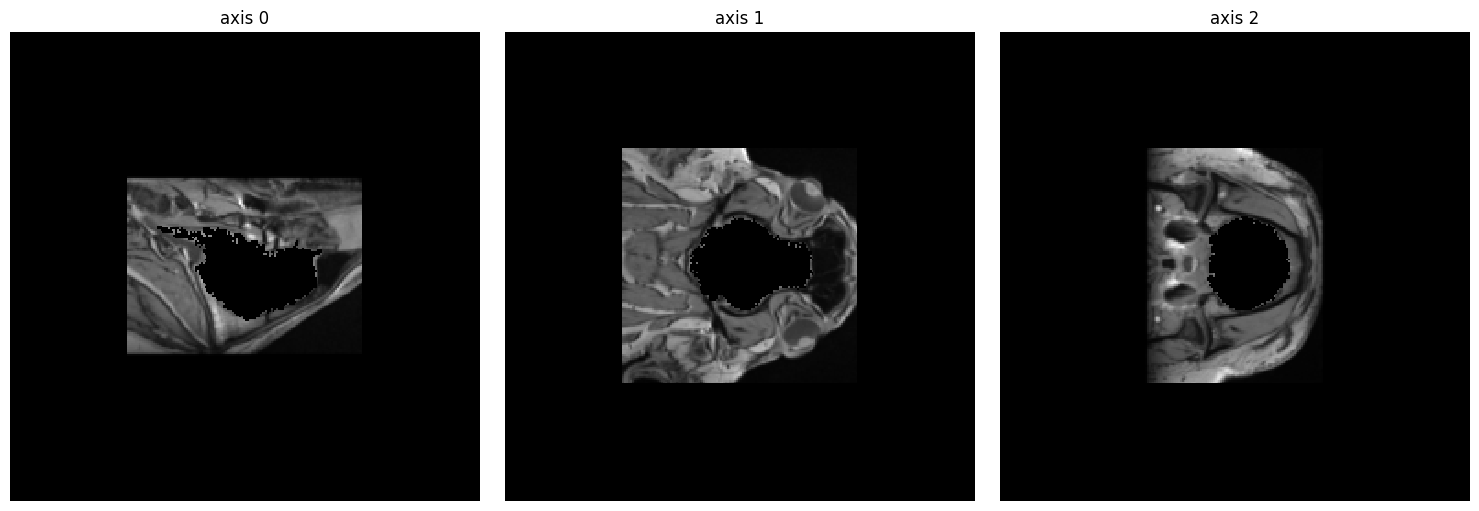

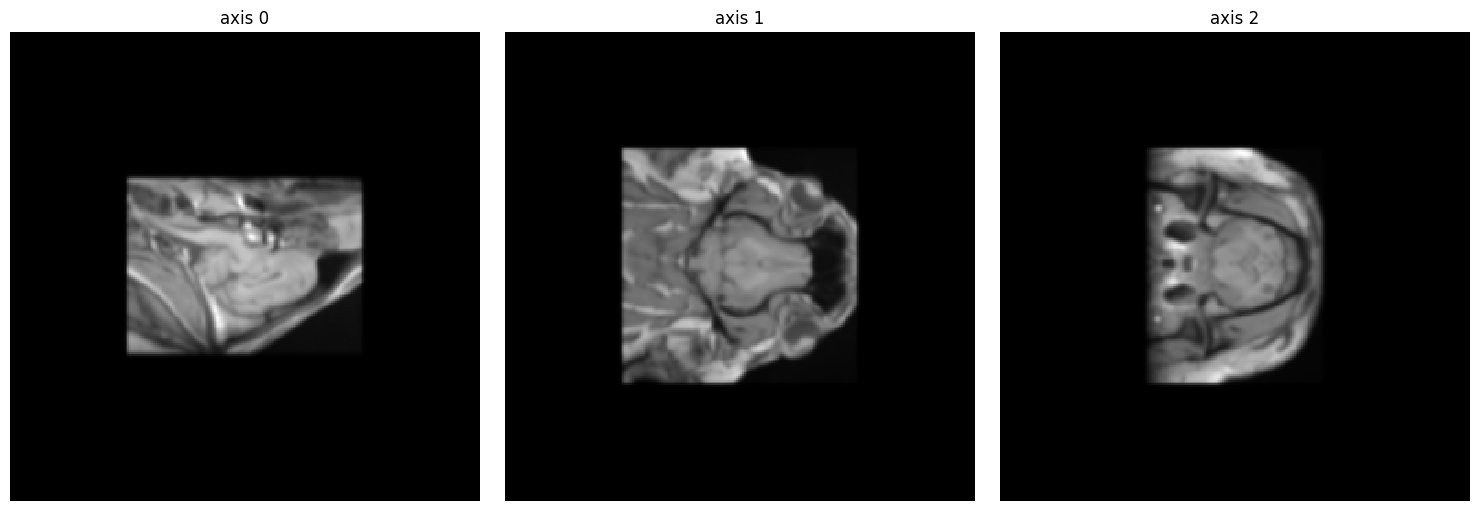

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [4]:
import numpy as np
import os
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
# Smooth the anatomy using Gaussian filter (with a chosen sigma)
pig_skull = np.copy(pig_anat)
pig_skull[pig_brain_mask == 1] = 0
sigma = 1  # Adjust sigma for desired smoothing effect
smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = pig_skull.flatten().reshape(-1, 1)

ne.plot.volume3D(brain_data.reshape((256,256,256)))
ne.plot.volume3D(non_brain_data.reshape((256,256,256)))
ne.plot.volume3D(smoothed_anat)

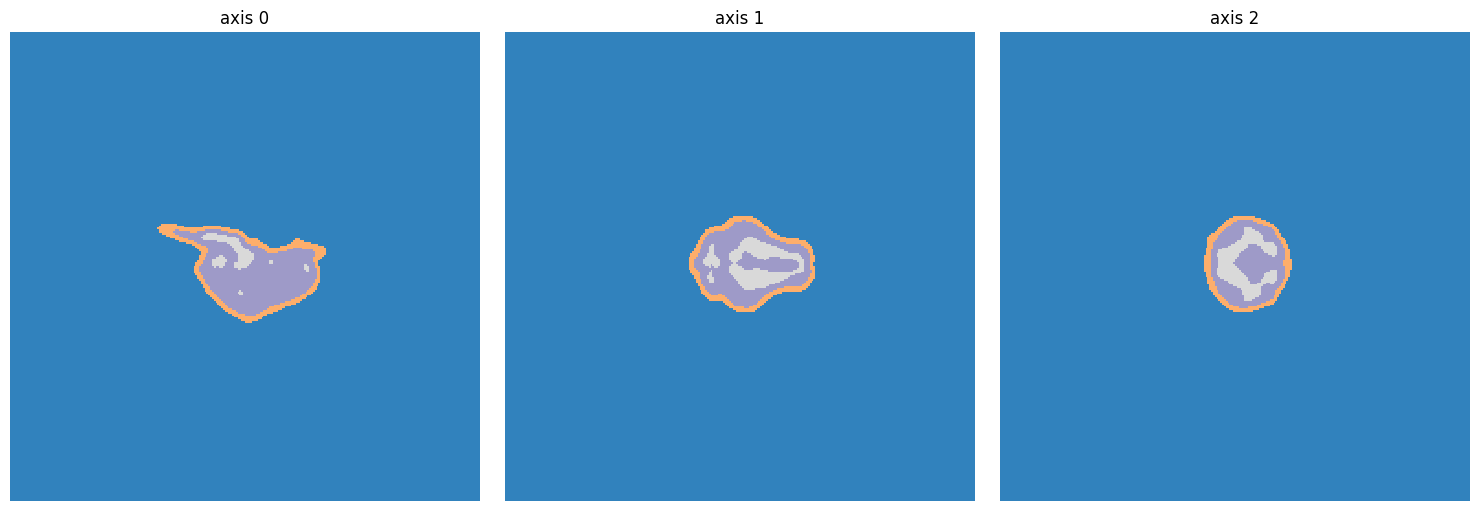

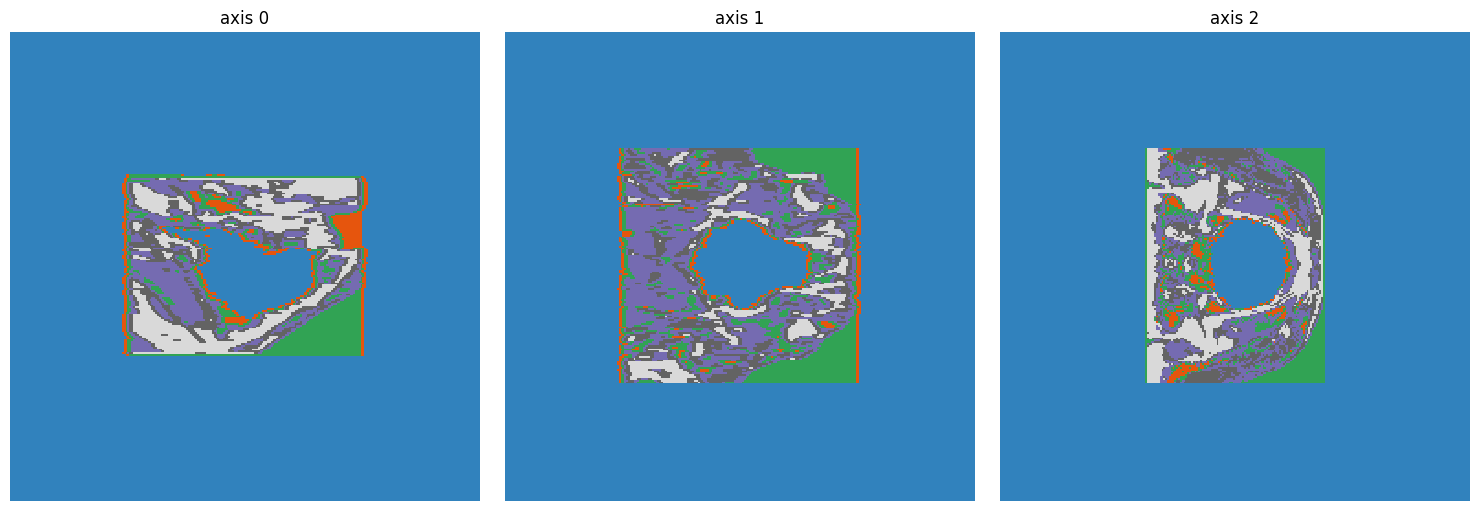

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [12]:
k1 = 6
k2=6

def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=2)
    return np.round(smoothed_labels).astype(int)
# Apply GMM for brain regions (assumes 29 brain regions to be classified)
# gmm_brain = GaussianMixture(n_components=k1, random_state=42)
# gmm_brain.fit(brain_data)  # Fit GMM on the brain data

# Apply GMM for non-brain regions (background and other tissues)
gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)  # 0 for background, 30-40 for other tissues
gmm_non_brain.fit(non_brain_data)  # Fit GMM on the non-brain data

# Predict the components (labels) for brain and non-brain regions
# predicted_brain_labels = gmm_brain.predict(brain_data)
predicted_brain_labels = pig_seg
predicted_non_brain_labels = gmm_non_brain.predict(non_brain_data)

predicted_brain_labels = make_smooth(predicted_brain_labels)
predicted_non_brain_labels = make_smooth(predicted_non_brain_labels)

predicted_brain_labels = predicted_brain_labels.reshape((256,256,256))
predicted_non_brain_labels = predicted_non_brain_labels.reshape((256,256,256))



ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])

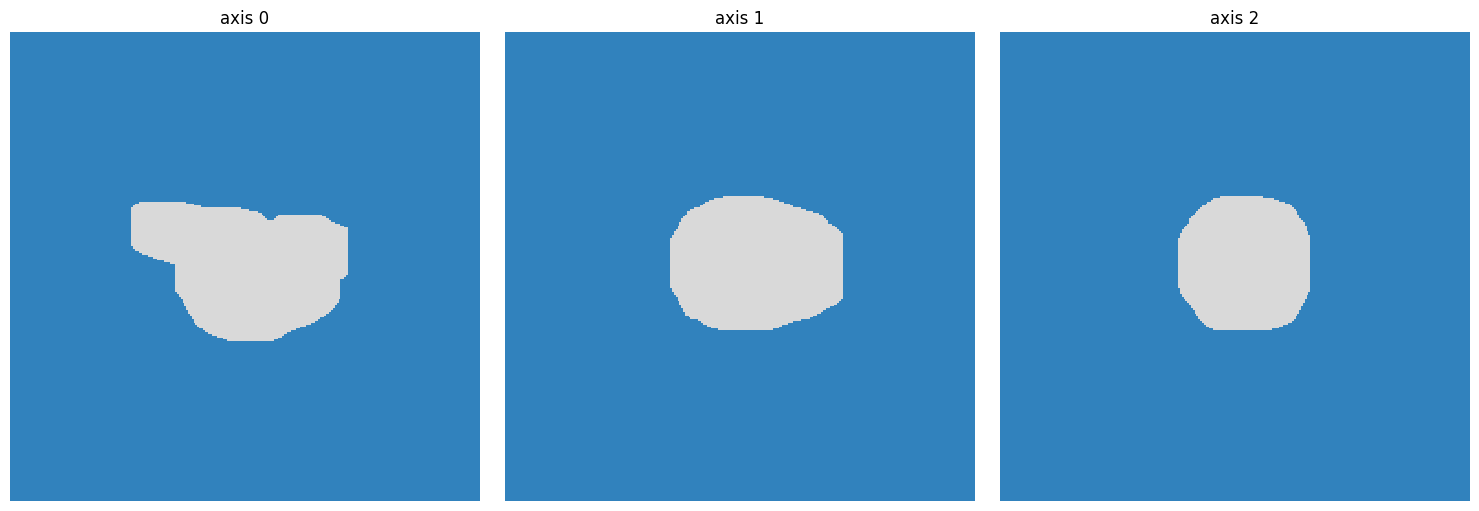

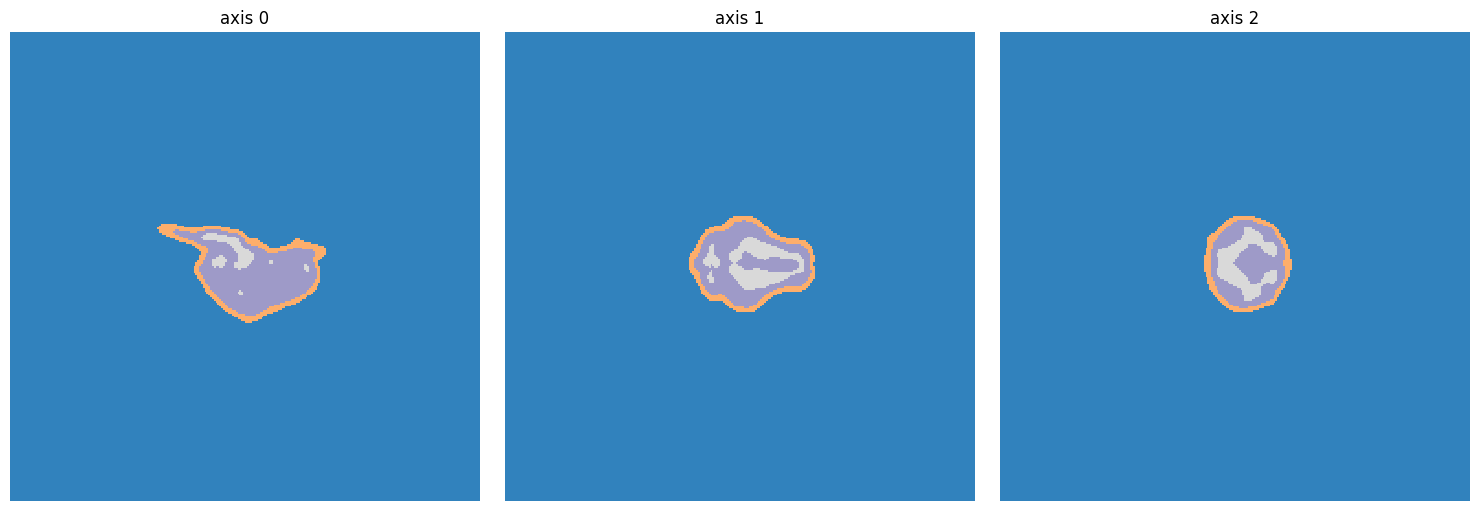

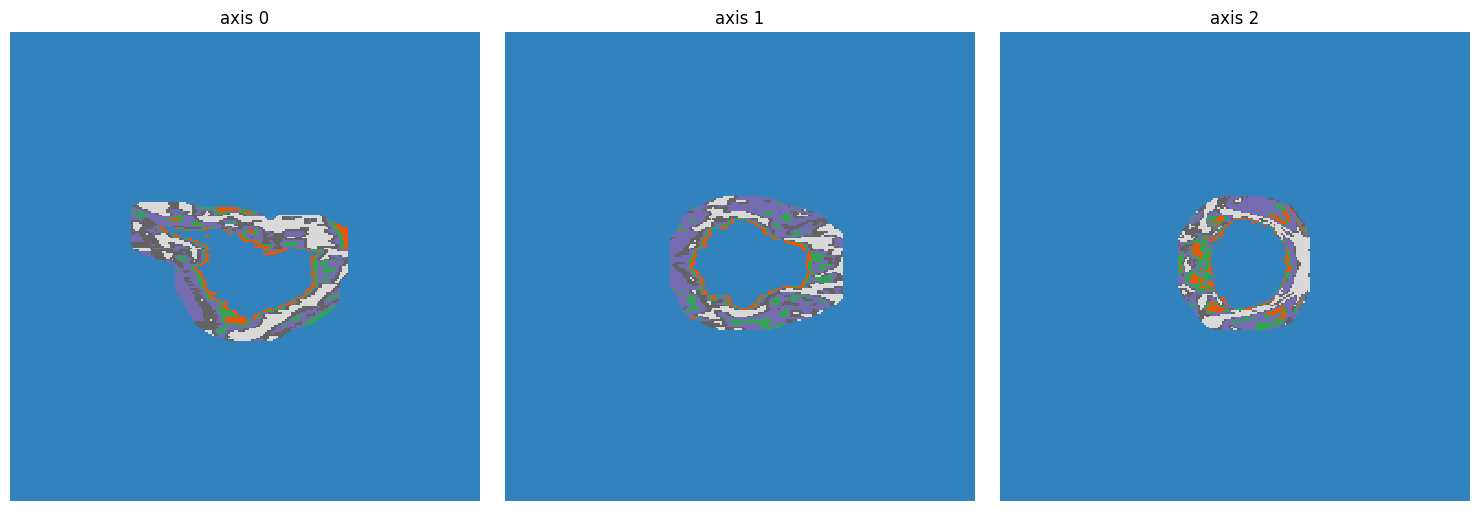

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [15]:
from scipy.ndimage import binary_dilation
structure = np.ones((3, 3, 3), dtype=bool)
dial_mask = binary_dilation(predicted_brain_labels>0, structure=structure, iterations=10)
predicted_non_brain_labels = predicted_non_brain_labels*(dial_mask>0)

ne.plot.volume3D(dial_mask,cmaps=['tab20c'])

ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
ne.plot.volume3D(predicted_non_brain_labels2,cmaps=['tab20c'])

In [16]:

# predicted_non_brain_labels[pig_brain_mask == 1] = 0
predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,7)
predicted_anat_labels = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)


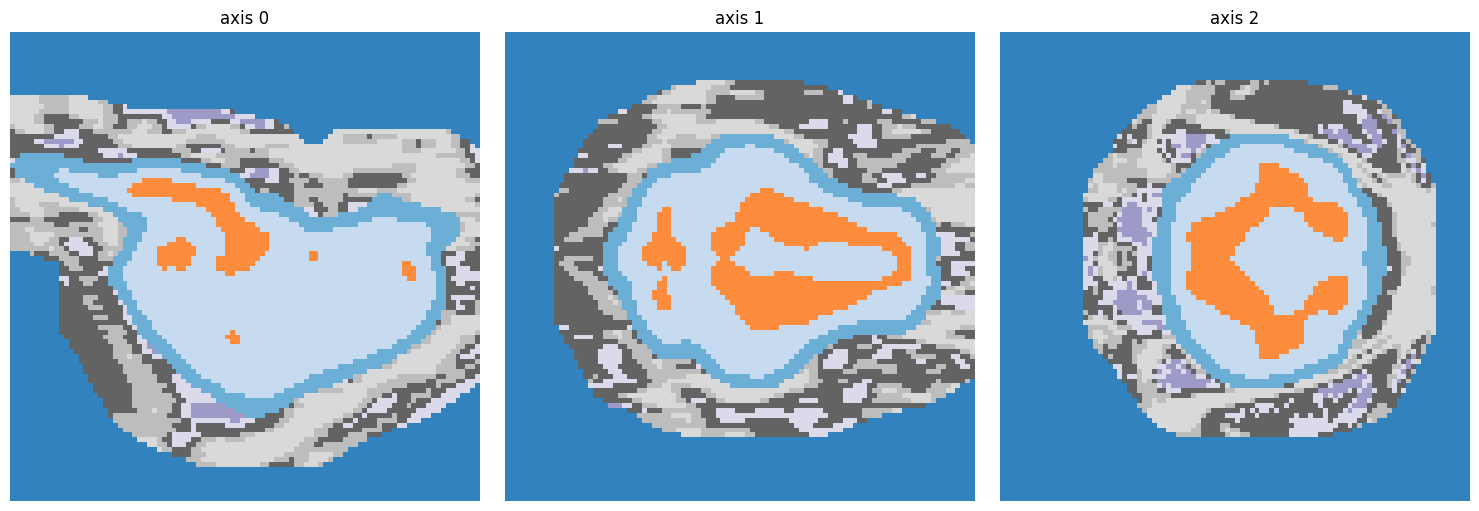

[ 0  8  9 10 11 12]
[0 1 2 3]
[ 0  1  2  3  8  9 10 11 12]


In [17]:

zoomed_predicted_anat_labels = sf.Volume(predicted_anat_labels).reshape([param_3d.img_size_96,]*3) # Use order=1 for bilinear interpolation
        
pig_brain_map = [zoomed_predicted_anat_labels]
# ne.plot.volume3D(predicted_non_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_anat_labels,cmaps=['tab20c'])
ne.plot.volume3D(zoomed_predicted_anat_labels,cmaps=['tab20c'])

print(np.unique(predicted_non_brain_labels))
print(np.unique(predicted_brain_labels))
print(np.unique(predicted_anat_labels))


In [13]:
with open("params_olfactory_96.json", "r") as json_file:
    config = json.load(json_file)
# pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_96)



model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_48"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]
model_pig_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]
model_shapes_config["in_shape"]=[ param_3d.img_size_96, param_3d.img_size_96, param_3d.img_size_96]

model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)

labels_to_image_model = create_model(model3_config)

fragment = next(gen)
# _, fg = model_pig(fragment)


In [14]:
fragment.shape

(1, 96, 96, 96, 1)

In [15]:
model_pig.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 96, 96, 96,  0           []                               
                                 1)]                                                              
                                                                                                  
 draw_affine_params_8 (DrawAffi  (None, 12)          0           ['input_0[0][0]']                
 neParams)                                                                                        
                                                                                                  
 params_to_affine_matrix_8 (Par  (None, 4, 4)        0           ['draw_affine_params_8[0][0]']   
 amsToAffineMatrix)                                                                        

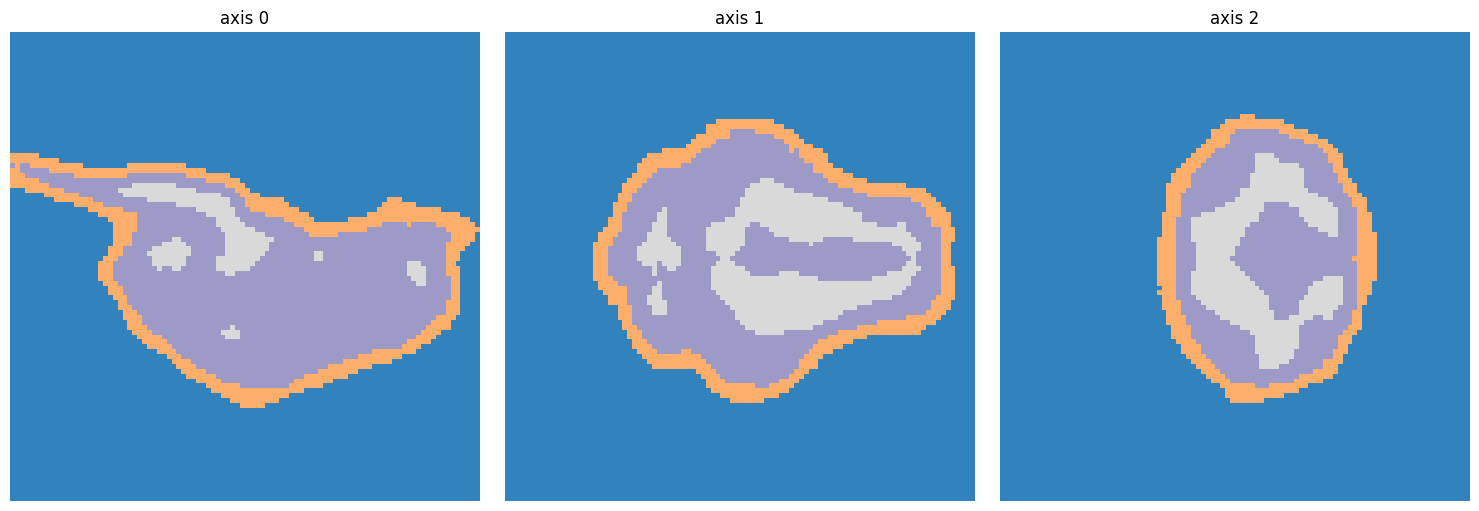

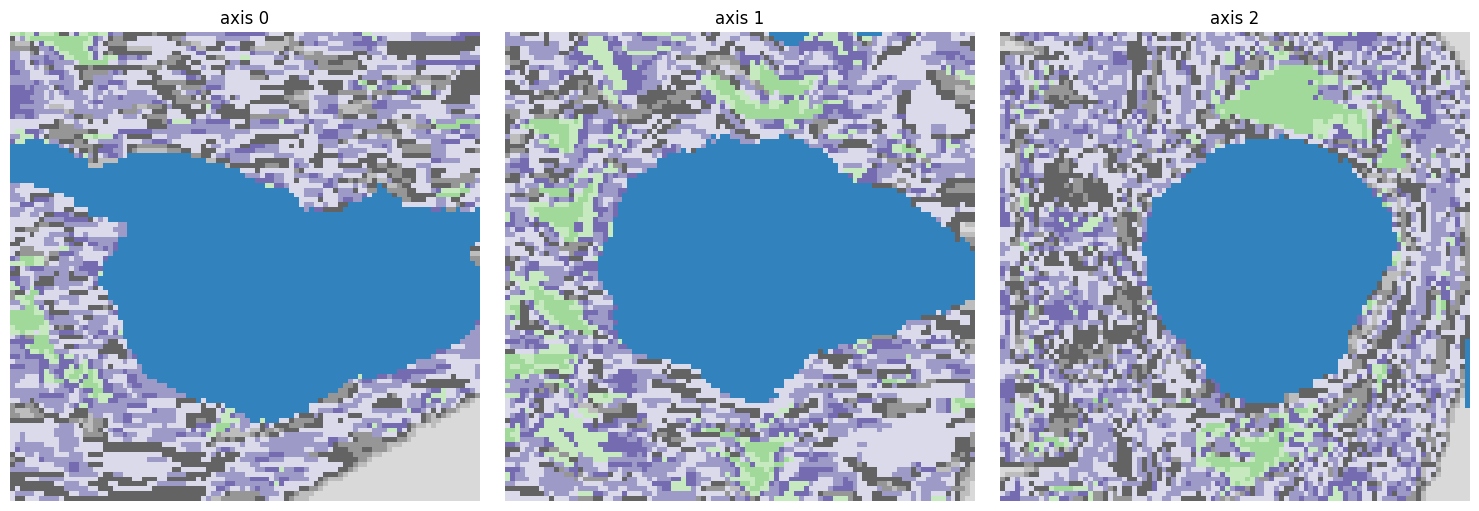

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [16]:
a = fragment[0, ...,0] 
fg_mask = (a >= 1) & (a <= 6)  

fragment_brain = tf.where(fg_mask, a, 0)
# fragment_brain = tf.where(fg_mask, 1, 0) 
_, fg = model_pig(fragment_brain[None,...,None])
ne.plot.volume3D(fg[0,...,0],cmaps=['tab20c'])

a = fragment[0, ...,0] 
bg_mask = (a > 6) | (a == 0)
fragment_bg = tf.where(bg_mask, a, 0)
_, bg = model_shapes(fragment_bg[None,...,None])
ne.plot.volume3D(bg[0,...,0],cmaps=['tab20c'])

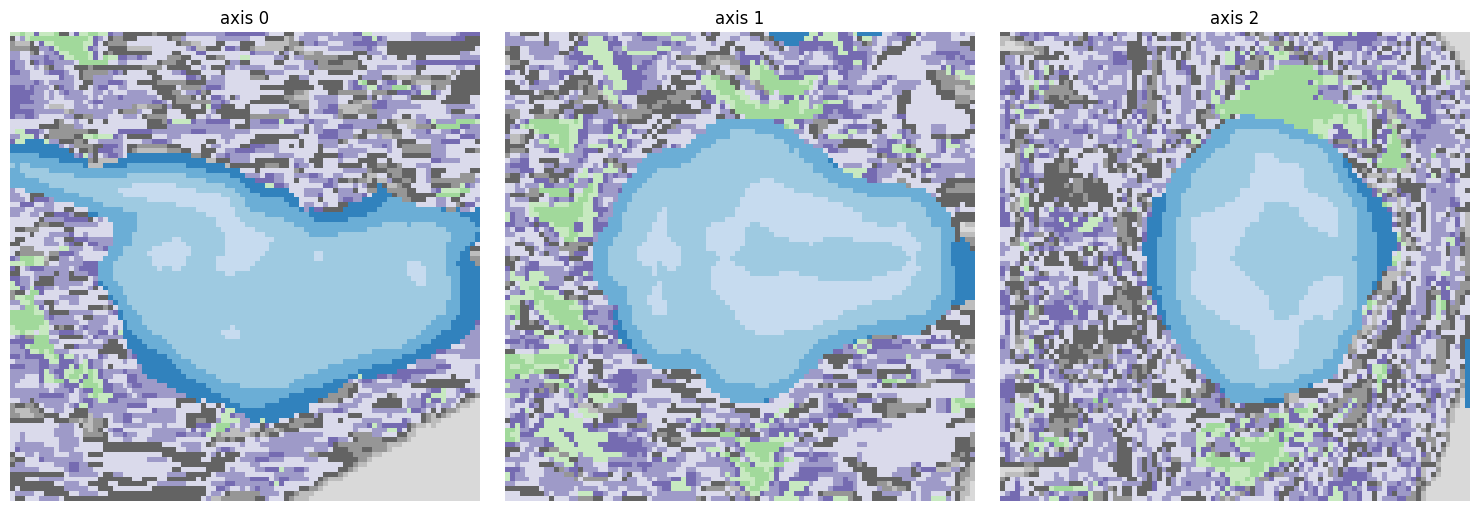

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [17]:
result = fg[0,...,0] + bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)
ne.plot.volume3D(result,cmaps=['tab20c'])


(1, 96, 96, 96, 1)
(96, 96, 96) 85575


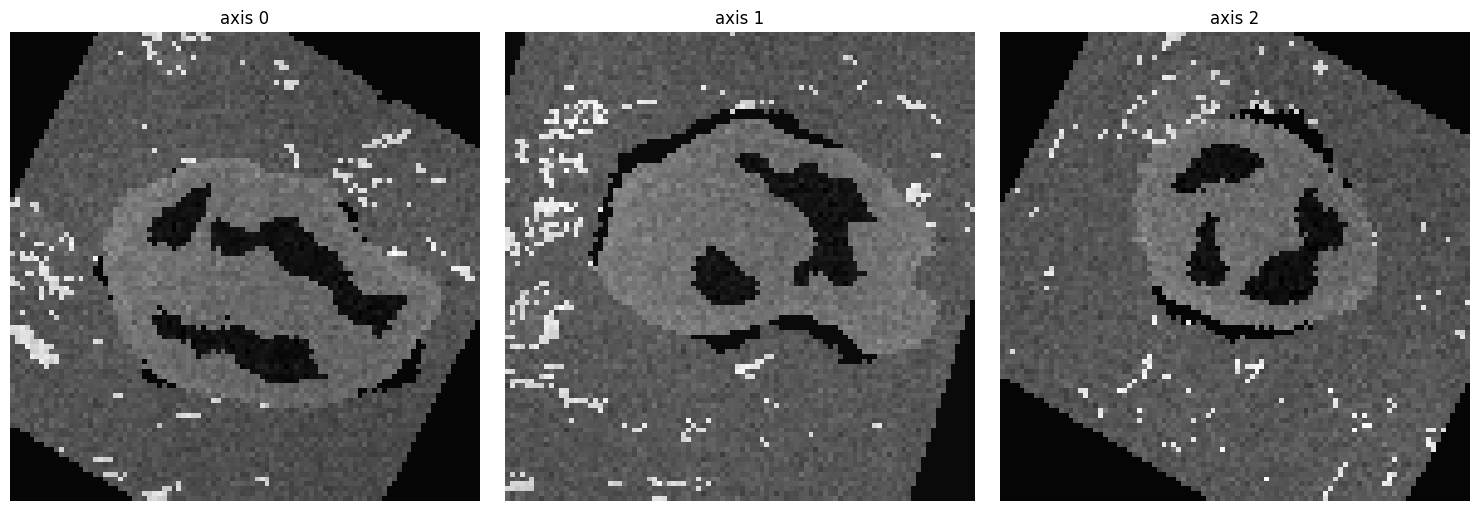

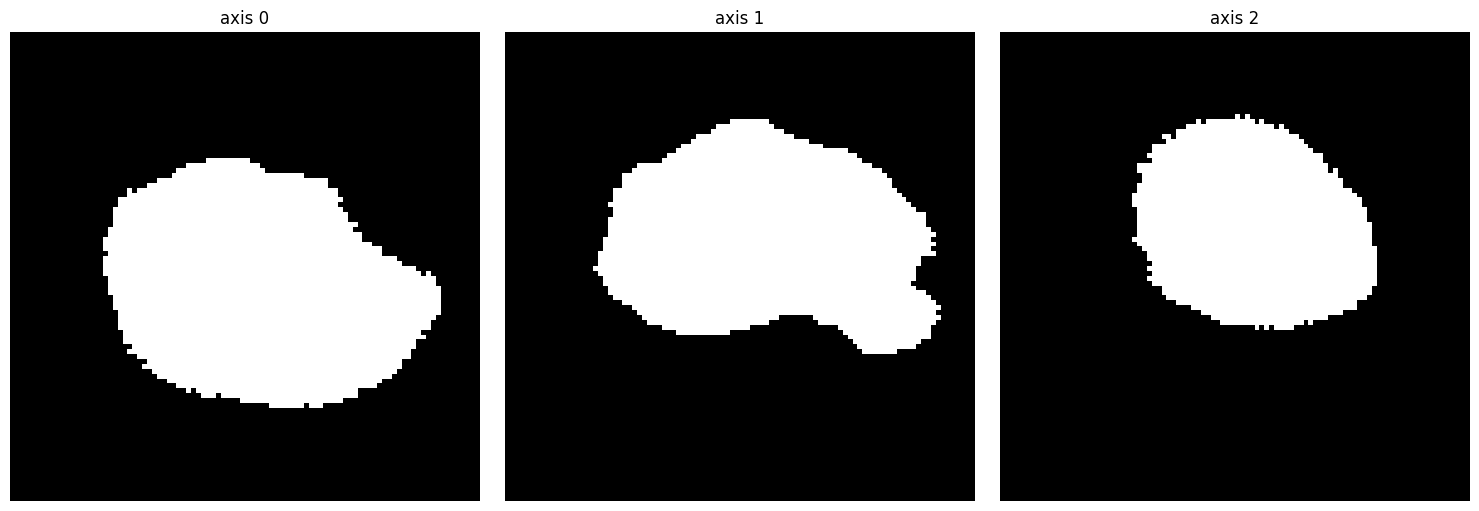

(1, 96, 96, 96, 1)
(96, 96, 96) 111094


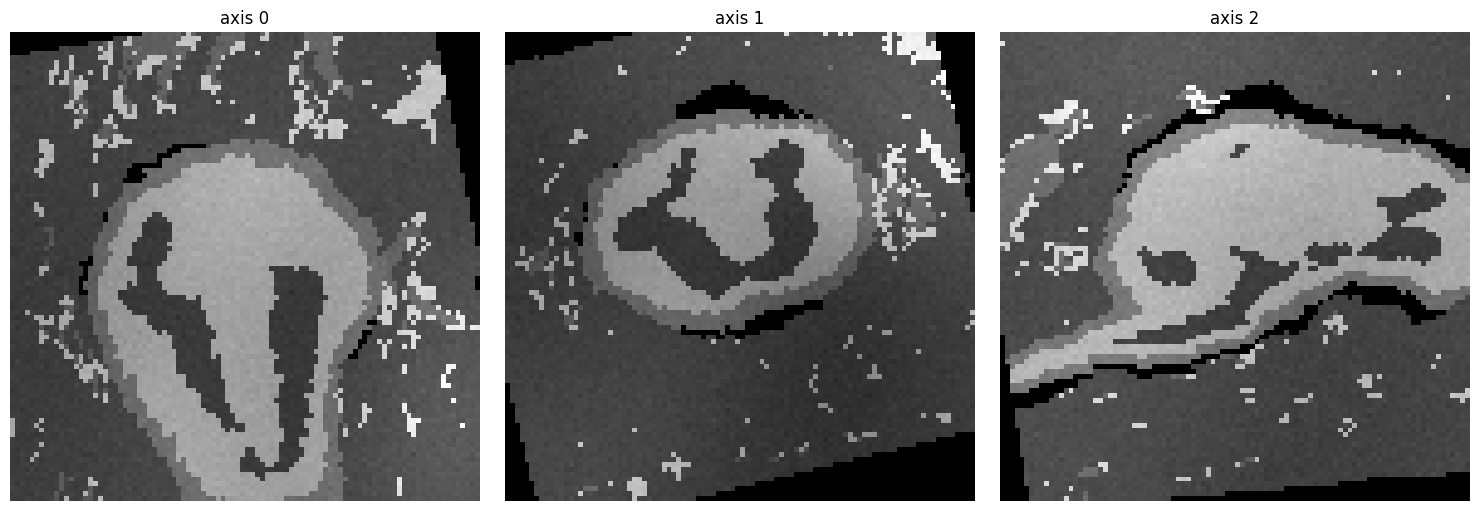

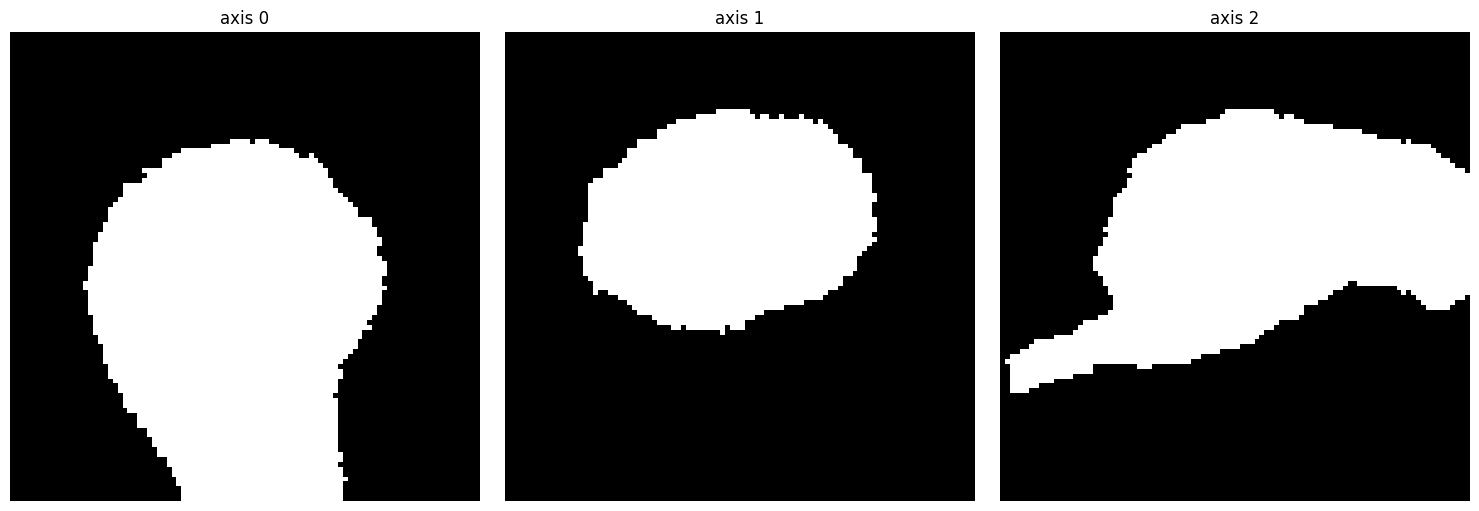

(1, 96, 96, 96, 1)
(96, 96, 96) 94309


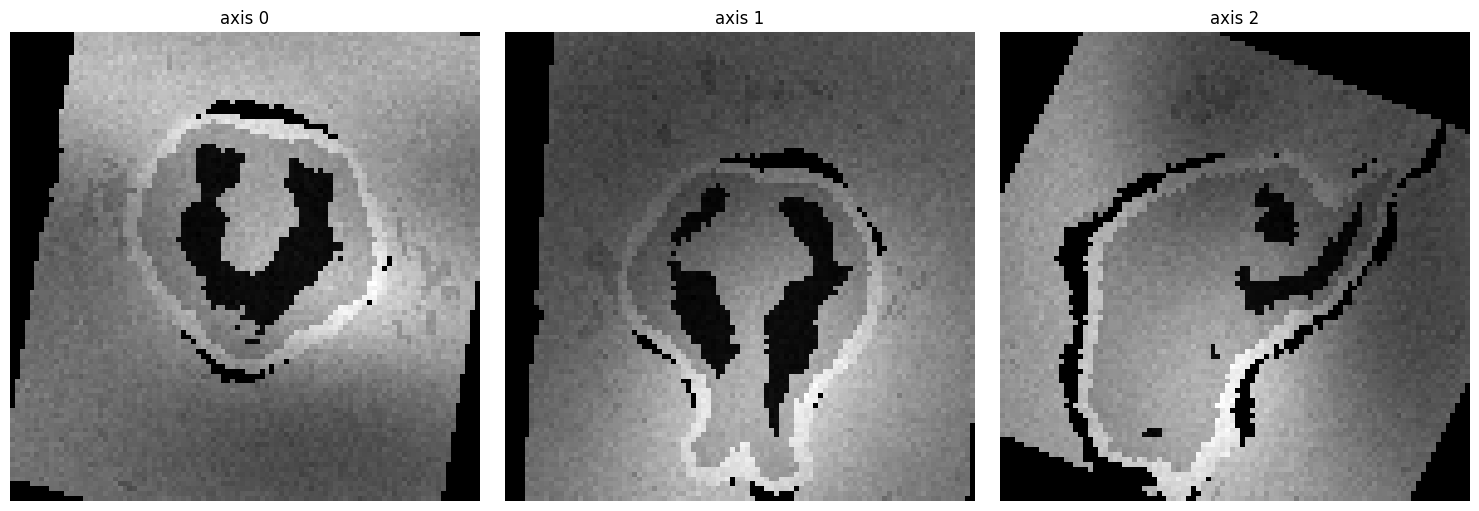

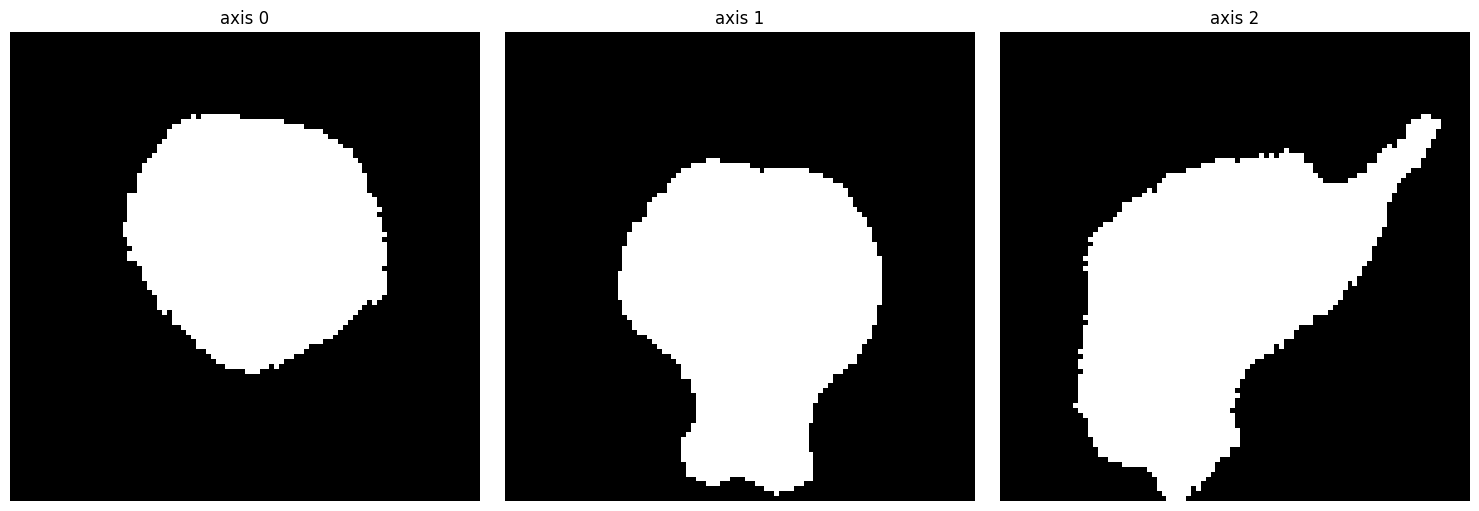

(1, 96, 96, 96, 1)
(96, 96, 96) 107847


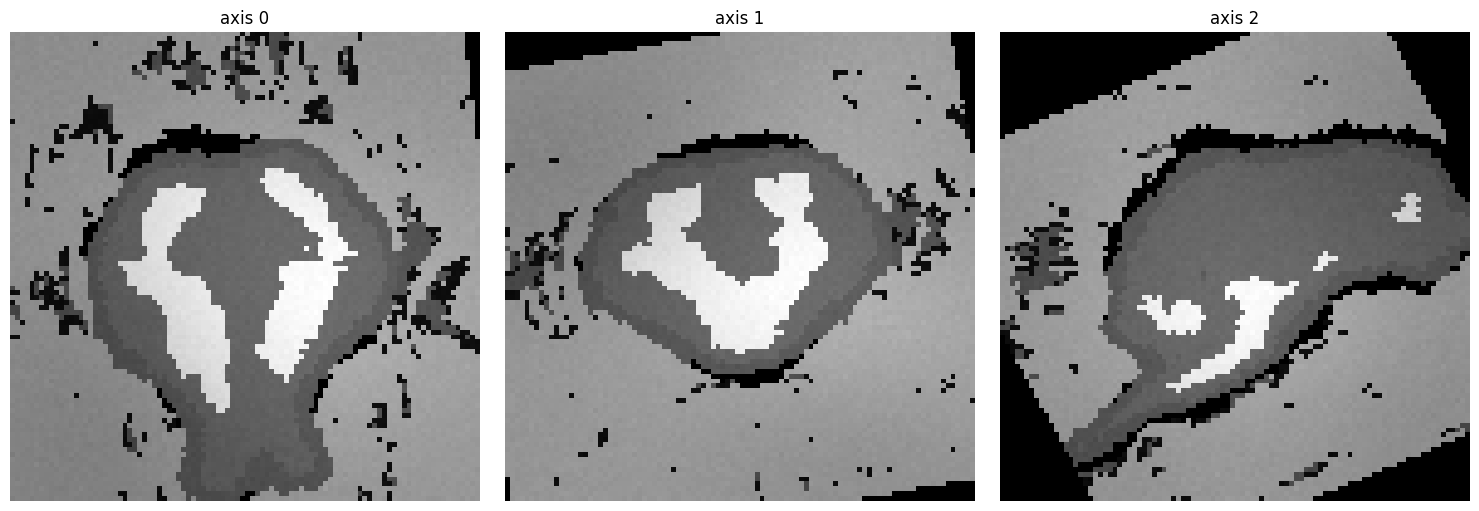

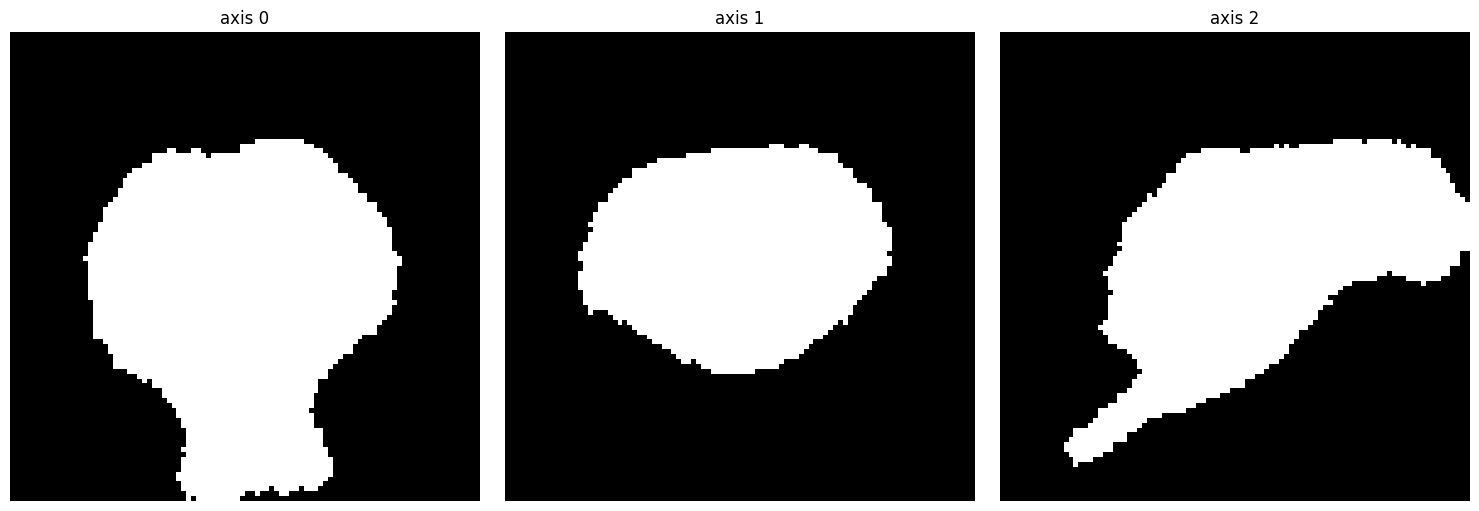

(1, 96, 96, 96, 1)
(96, 96, 96) 98133


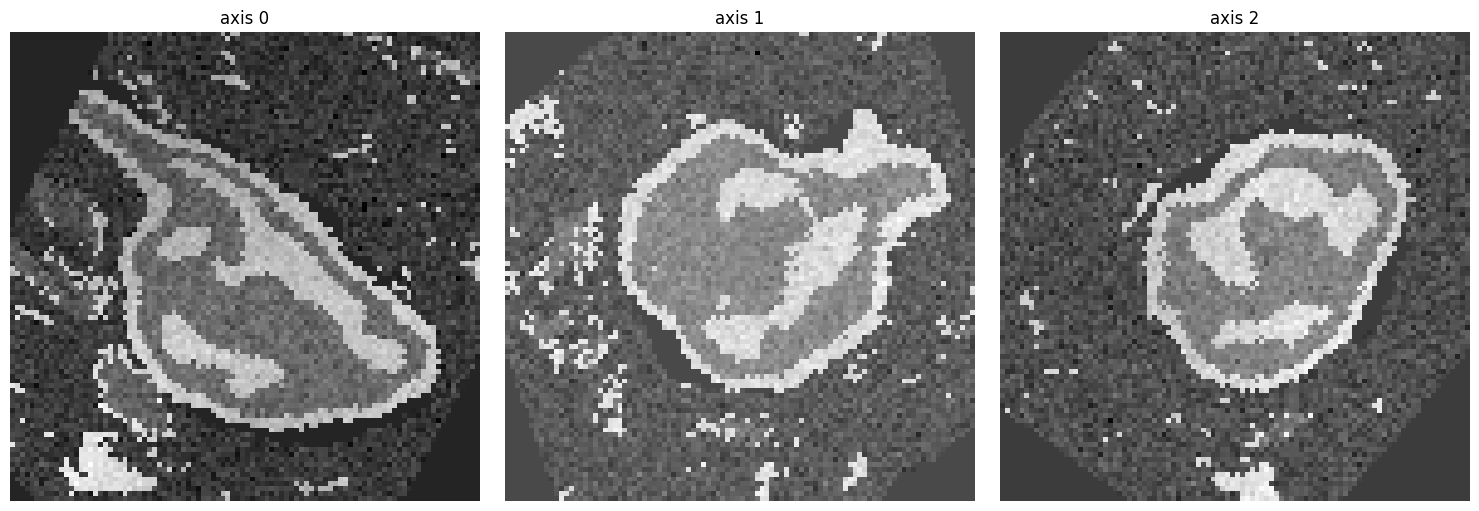

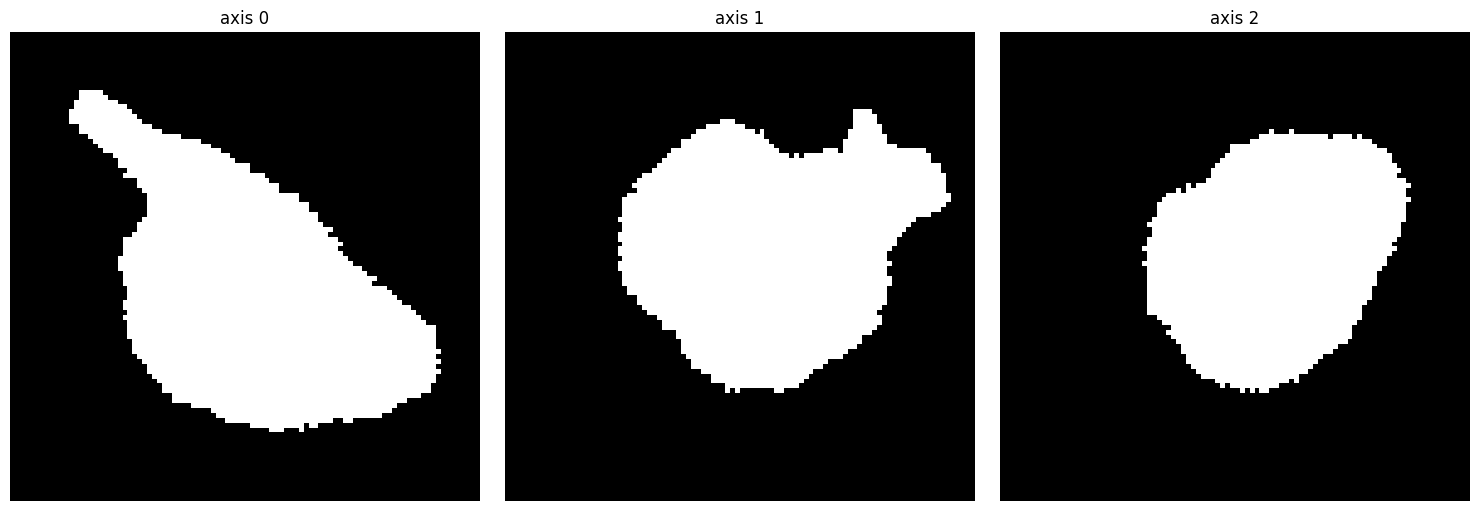

In [18]:
for i in range(5):
    labels_to_image_model = create_model(model3_config)
    generated_img, y = labels_to_image_model(result[None,...,None])
    
    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    mask = np.argmax(y,axis=-1)[0]
    print(mask.shape,np.sum(mask))
    ne.plot.volume3D(generated_img,slice_nos=ms);
    ne.plot.volume3D(mask,slice_nos=ms);
    nib.save(nib.Nifti1Image(generated_img[0,...,0].numpy(), np.eye(4)),os.path.join("synth_data", str(i)+'_img.nii.gz'))
    nib.save(nib.Nifti1Image(mask.astype(np.int32), np.eye(4)),os.path.join("synth_data", str(i)+'_mask.nii.gz'))

In [25]:
generated_img[0,...,0].numpy().shape

(96, 96, 96)

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


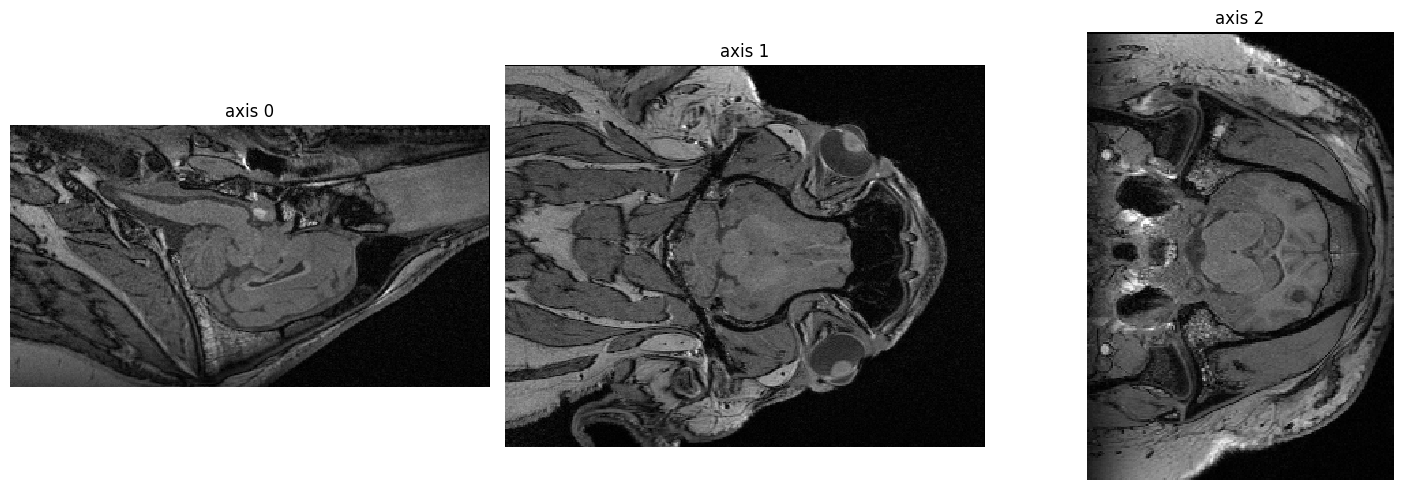

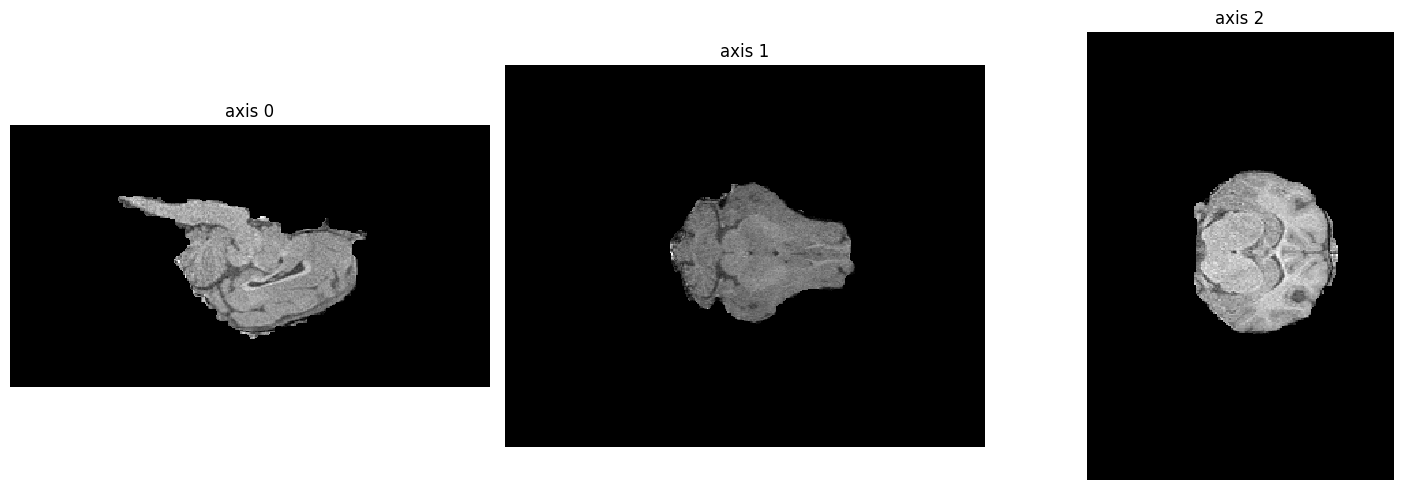

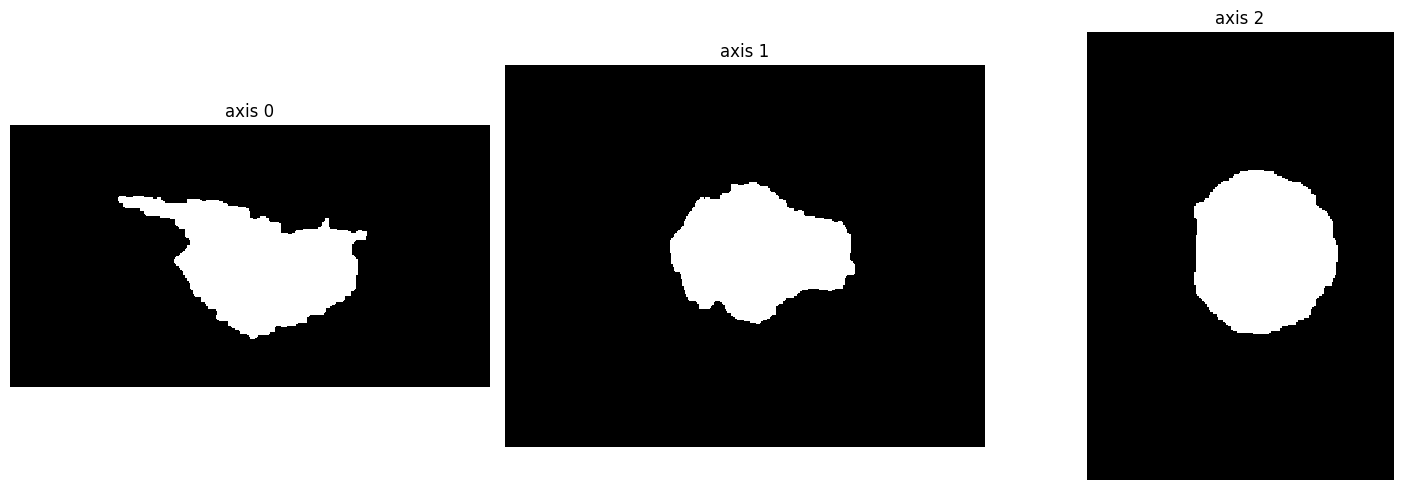

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [26]:
from scipy.ndimage import distance_transform_edt
import scipy.ndimage as ndi

folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).data#.reshape([param_3d.img_size_192,]*3).data
 #sf.load_volume(os.path.join(folder_path, 'anat_brain.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).data#.reshape([param_3d.img_size_192,]*3).data
# geom_data=sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_192,]*3).geom

# Step 1: Fill Holes Inside the Mask
pig_brain_mask_filled = ndi.binary_fill_holes(pig_brain_mask)

from scipy.ndimage import binary_closing, binary_opening

# Apply morphological closing (fills small holes)
closed_mask = binary_closing(pig_brain_mask_filled, structure=np.ones((3,3,3)))

# Apply morphological opening (removes small protrusions)
pig_brain_mask = binary_opening(closed_mask, structure=np.ones((3,3,3)))


pig_brain = pig_anat * (pig_brain_mask == 1)
ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask)

In [59]:
# nib.save(nib.Nifti1Image(pig_anat.astype(np.int32), np.array(geom_data.vox2world)),os.path.join(folder_path, 'anat.nii.gz'))
nib.save(nib.Nifti1Image(pig_brain.astype(np.int32), np.eye(4)),os.path.join(folder_path, 'anat_brain.nii.gz'))
# nib.save(nib.Nifti1Image(pig_brain_mask.astype(np.int32), np.array(geom_data.vox2world)),os.path.join(folder_path, 'anat_brain_mask.nii.gz'))

In [21]:
np.array(geom_data.vox2world)

array([[-5.39772749e-01,  0.00000000e+00, -2.64326712e-12,
         7.43575211e+01],
       [ 0.00000000e+00, -5.39999962e-01,  0.00000000e+00,
         6.77581120e+00],
       [-2.64326712e-12,  0.00000000e+00,  5.39772749e-01,
        -9.02229462e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [50]:
pig_anat.shape

(192, 192, 192)

In [144]:
predicted_anat_labels=[]

geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_seg = sf.load_volume(os.path.join(folder_path, 'fast_segmentation_seg.nii.gz')).resize(1).reshape([param_3d.img_size_256,]*3).data

pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_256,]*3).data
sigma = 1  # Adjust sigma for desired smoothing effect
pig_anat = gaussian_filter(pig_anat, sigma=sigma)

pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_256,]*3).data
pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_brain = pig_anat * (pig_brain_mask == 1)
scaling_factor = 0.5
pig_anat = sf.Volume(zoom(pig_anat, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain = sf.Volume(zoom(pig_brain, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = sf.Volume(zoom(pig_brain_mask, scaling_factor, order=1)).reshape((256,)*3).data
pig_brain_mask = ndi.binary_fill_holes(pig_brain_mask)
pig_seg = sf.Volume(zoom(pig_seg, scaling_factor, order=1)).reshape((256,)*3)

pig_skull = np.copy(pig_anat)
pig_skull[pig_brain_mask == 1] = 0
sigma = 1  # Adjust sigma for desired smoothing effect
smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = pig_skull.flatten().reshape(-1, 1)

def make_smooth(label_map):
    smoothed_labels = gaussian_filter(label_map.astype(float), sigma=1)
    return np.round(smoothed_labels).astype(int)
    
# Apply GMM for brain regions (assumes 29 brain regions to be classified)
gmm_brain = GaussianMixture(n_components=k1, random_state=42)
gmm_brain.fit(brain_data)  # Fit GMM on the brain data

# Apply GMM for non-brain regions (background and other tissues)
gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)  # 0 for background, 30-40 for other tissues
gmm_non_brain.fit(non_brain_data)  # Fit GMM on the non-brain data

# Predict the components (labels) for brain and non-brain regions
predicted_brain_labels = gmm_brain.predict(brain_data)

if k1==0:
    predicted_brain_labels = pig_seg
    
predicted_non_brain_labels = gmm_non_brain.predict(non_brain_data)

predicted_brain_labels = make_smooth(predicted_brain_labels)
predicted_non_brain_labels = make_smooth(predicted_non_brain_labels)


predicted_brain_labels = predicted_brain_labels.reshape((256,256,256))
predicted_non_brain_labels = predicted_non_brain_labels.reshape((256,256,256))

predicted_non_brain_labels[pig_brain_mask == 1] = 0
predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,6)
predicted_anat_label = np.where(predicted_brain_labels > 0, predicted_brain_labels, predicted_non_brain_labels)

zoomed_predicted_anat_labels = sf.Volume(predicted_anat_label).reshape([param_3d.img_size_192,]*3)
predicted_anat_labels.append(zoomed_predicted_anat_labels)

with open("params_gmm_192.json", "r") as json_file:
    config = json.load(json_file)
# pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(predicted_anat_labels,param_3d.img_size_192)



model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_48"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_pig_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_shapes_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]

model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)

labels_to_image_model = create_model(model3_config)

fragment = next(gen)
# _, fg = model_pig(fragment)


[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


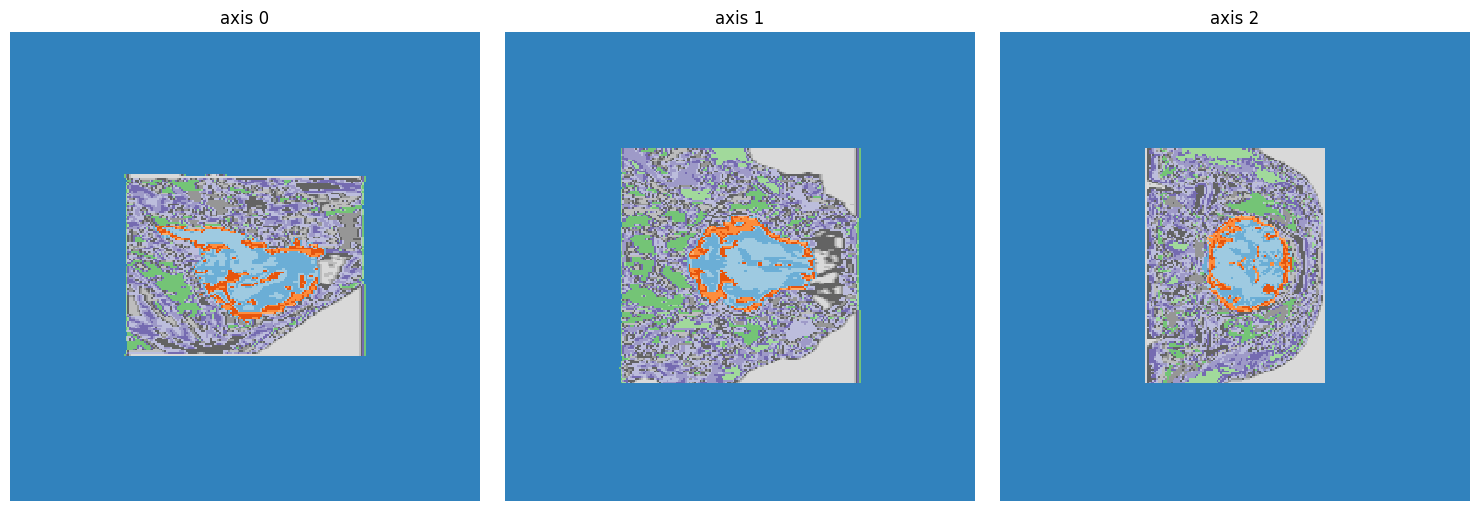

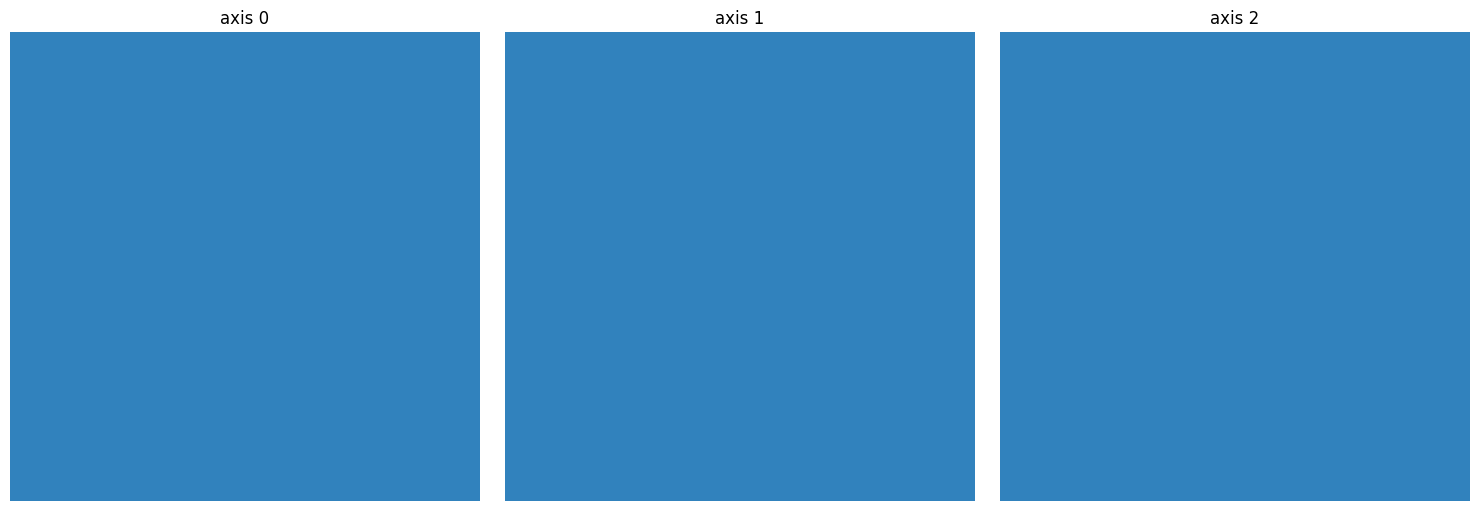

[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15]


In [139]:
ne.plot.volume3D(predicted_anat_label,cmaps=['tab20c'])
ne.plot.volume3D(predicted_anat_labels[0],cmaps=['tab20c'])

print(np.unique(predicted_anat_label))

In [143]:
np.sum(predicted_anat_labels)

0.0